# Training CGNet

Purpose:
--------
The purpose of this notebook is to train CGnet for machine learning detection of atmospheric rivers and tropical cyclones.\
See ClimateNet repo here: https://github.com/andregraubner/ClimateNet

Authors/Contributors:
---------------------
* Teagan King
* John Truesdale
* Katie Dagon

## Import libraries

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/glade/work/kdagon/ClimateNet") # append path to ClimateNet repo
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

from os import path

In [2]:
%load_ext watermark
%watermark -iv

json  2.0.9
numpy 1.18.1



## Config file
Use `get_averages_and_standard_devs.ipynb` to calculate means/stds for given training dataset.

In [13]:
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_021523.json') # weighted mean, unweighted std; TMQ, U850, V850, PSL
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_040523.json') # unweighted mean and std; TMQ, U850, V850, PSL
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_092023_TMQ_V850.json') # unweighted mean and std, TMQ and V850 only
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_092023_TMQ.json') # unweighted mean and std, TMQ only
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_101025_TMQ_U850_V850.json') # unweighted mean and std, TMQ, U850 and V850 only
config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_112425.json') # unweighted mean and std; TMQ, U850, V850, PSL; extended training to 40 epochs

In [14]:
config.description

'The basic CGNet model. You can use this config to train your own model, or load it with our trained weights.'

In [15]:
config.train_batch_size

16

## Confirm GPU resources
Can request through JupyterHub launch page.\
Current resources request (2/15/23): 1 node, 4 cpu, 64GB mem, 2 V100 GPU\
4/5/23: Noticed that not all CPU/mem was needed, new request: 1 node, 2 cpu, 64GB mem, 2 V100 GPU

In [6]:
# requires loading pytorch into environment
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
2


## Instantiate CGNet model given config file
This step needs GPU resources (as written)

In [16]:
%%time
cgnet = CGNet(config)

CPU times: user 49.8 ms, sys: 254 µs, total: 50.1 ms
Wall time: 49.1 ms


In [17]:
cgnet.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## Set train, test data

In [9]:
train_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new"

train = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
test = ClimateDatasetLabeled(path.join(train_path, 'test'), config)

In [10]:
train.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [11]:
train.length

398

In [18]:
config.epochs

40

## Train model - TMQ, U850, V850, PSL

Memory use holding at ~14GB during training\
Each epoch takes ~1 min to run

In [18]:
cgnet.train(train) # use ~20 epochs for non-test
# IOU mean should be around 0.75 after all epochs?
# weights and measures site to look at ML performance
# maybe playing with those parameters could improve model

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


Loss: 0.8389822244644165:  16%|█▌        | 4/25 [00:16<01:46,  5.06s/it]Process Process-3:
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14df3c6aa2e8>>
Traceback (most recent call last):
  File "/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/glade/u

KeyboardInterrupt: 

2/15/23: Training is maxing out around 0.5977 IOU mean at last epoch\
4/5/23: With updated unweighted means, similar performance: 0.5996 IOU mean at last epoch

### 1/17/24: test training again for CUDA memory issues

In [13]:
cgnet.train(train)

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.78529928e+08 6.72962300e+06 4.52611480e+07]
 [1.08803000e+06 2.54923000e+05 2.83394000e+05]
 [6.13608100e+06 2.85935000e+05 1.35558660e+07]]
IOUs:  [0.82467567 0.02949847 0.20688896] , mean:  0.35368770066281535
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.15756671e+08 6.17424000e+05 1.41466040e+07]
 [9.33795000e+05 5.69462000e+05 1.23090000e+05]
 [7.91407300e+06 7.72440000e+04 1.19865650e+07]]
IOUs:  [0.93042403 0.24535042 0.34999747] , mean:  0.5085906409368053
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16643609e+08 9.00293000e+05 1.29767970e+07]
 [7.71213000e+05 7.49808000e+05 1.05326000e+05]
 [7.33637400e+06 9.69390000e+04 1.25445690e+07]]
IOUs:  [0.93507726 0.28579585 0.37944849] , mean:  0.5334405339768861
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16940592e+08 8.80648000e+05 1.26994590e+07]
 [7.05032000e+05 8.24370000e+05 9.69450000e+04]
 [6.92696100e+06 8.93180000e+04 1.29616030e+07]]
IOUs:  [0.93727065 0.31751565 0.39548087] , mean:  0.5500890525658393
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17395301e+08 9.43248000e+05 1.21821500e+07]
 [6.69528000e+05 8.61394000e+05 9.54250000e+04]
 [6.79228300e+06 8.74630000e+04 1.30981360e+07]]
IOUs:  [0.93908795 0.32419089 0.40607504] , mean:  0.5564512922652498
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17057357e+08 9.65791000e+05 1.24975510e+07]
 [6.58027000e+05 8.78076000e+05 9.02440000e+04]
 [6.55078700e+06 8.97720000e+04 1.33373230e+07]]
IOUs:  [0.93879079 0.32740696 0.40955153] , mean:  0.5585830956263667
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17680559e+08 1.00887600e+06 1.18312640e+07]
 [6.16481000e+05 9.22426000e+05 8.74400000e+04]
 [6.47325700e+06 8.23920000e+04 1.34222330e+07]]
IOUs:  [0.94096783 0.33942483 0.42080469] , mean:  0.5670657810792699
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17463904e+08 1.00533400e+06 1.20514610e+07]
 [6.06197000e+05 9.32206000e+05 8.79440000e+04]
 [6.29473500e+06 8.19020000e+04 1.36012450e+07]]
IOUs:  [0.94085226 0.34353325 0.42348673] , mean:  0.5692907497254828
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17635986e+08 1.05167700e+06 1.18330360e+07]
 [5.98575000e+05 9.46642000e+05 8.11300000e+04]
 [6.21679600e+06 8.47770000e+04 1.36763090e+07]]
IOUs:  [0.94160102 0.3426385  0.42883132] , mean:  0.5710236124789473
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18130448e+08 1.09154000e+06 1.12987110e+07]
 [5.80841000e+05 9.66010000e+05 7.94960000e+04]
 [6.08309000e+06 8.45200000e+04 1.38102720e+07]]
IOUs:  [0.94349036 0.34470725 0.4404335 ] , mean:  0.5762103685617176
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17892587e+08 1.05161000e+06 1.15765020e+07]
 [5.72919000e+05 9.70853000e+05 8.25750000e+04]
 [5.96690900e+06 7.95190000e+04 1.39314540e+07]]
IOUs:  [0.94313205 0.35208031 0.44035376] , mean:  0.5785220421650871
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18117398e+08 1.07029500e+06 1.13330060e+07]
 [5.77579000e+05 9.65219000e+05 8.35490000e+04]
 [5.85597700e+06 8.15760000e+04 1.40403290e+07]]
IOUs:  [0.94409669 0.34742378 0.44722347] , mean:  0.5795813140152989
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1827078e+08 1.0864030e+06 1.1163516e+07]
 [5.6148900e+05 9.8387600e+05 8.0982000e+04]
 [5.8077180e+06 8.2696000e+04 1.4087468e+07]]
IOUs:  [0.94473231 0.35195672 0.45119776] , mean:  0.5826289311486051
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18239297e+08 1.08886200e+06 1.11925400e+07]
 [5.50996000e+05 9.93160000e+05 8.21910000e+04]
 [5.64330300e+06 7.96790000e+04 1.42549000e+07]]
IOUs:  [0.94512956 0.35534877 0.45611866] , mean:  0.585532327937042
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18317114e+08 1.10035200e+06 1.11032330e+07]
 [5.42279000e+05 1.00158800e+06 8.24800000e+04]
 [5.66892400e+06 8.53270000e+04 1.42236310e+07]]
IOUs:  [0.94531321 0.35618021 0.45641817] , mean:  0.5859705274891225
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1814128e+08 1.1062190e+06 1.1273200e+07]
 [5.3409400e+05 1.0132350e+06 7.9018000e+04]
 [5.5700310e+06 8.3319000e+04 1.4324532e+07]]
IOUs:  [0.94509156 0.35982826 0.4572131 ] , mean:  0.5873776384268634
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18348627e+08 1.04940200e+06 1.11226700e+07]
 [5.30420000e+05 1.01409900e+06 8.18280000e+04]
 [5.45397500e+06 8.27460000e+04 1.44411610e+07]]
IOUs:  [0.94604401 0.36762764 0.46311927] , mean:  0.5922636370114416
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18582749e+08 1.06311500e+06 1.08748350e+07]
 [5.23684000e+05 1.01857800e+06 8.40850000e+04]
 [5.37021200e+06 8.12920000e+04 1.45263780e+07]]
IOUs:  [0.94699443 0.36761762 0.46955008] , mean:  0.5947207139968763
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18486338e+08 1.09381500e+06 1.09405460e+07]
 [5.09493000e+05 1.03454700e+06 8.23070000e+04]
 [5.23312600e+06 7.97520000e+04 1.46650040e+07]]
IOUs:  [0.94713375 0.36949242 0.47305343] , mean:  0.5965598670768206
Epoch 20:


Loss: 0.7790796756744385: 100%|██████████| 25/25 [01:17<00:00,  3.12s/it]

Epoch stats:
[[3.18706743e+08 1.07271500e+06 1.07412410e+07]
 [5.14033000e+05 1.03306800e+06 7.92460000e+04]
 [5.25433600e+06 8.10900000e+04 1.46424560e+07]]
IOUs:  [0.94771663 0.37158688 0.47542959] , mean:  0.598244367097974


### 1/22/24: test training again for A100 GPUs on casper
For some reason, using A100 GPUs on casper is slower (to initalize) and fails on training. Why?

In [14]:
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [01:39<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

### 1/22/24: test training again for A100 GPUs on derecho
Thinking the A100 issues with speed/errors here could be due to the outdated python environment: python/torch/cuda versions

In [13]:
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [01:33<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

### 11/24/25: test training for longer
the x/25 comes from training size (398) divided by batch size (16)

In [19]:
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.78531658e+08 6.73104600e+06 4.52579950e+07]
 [1.08757900e+06 2.55560000e+05 2.83208000e+05]
 [6.13742900e+06 2.86273000e+05 1.35541800e+07]]
IOUs:  [0.8246786  0.02956616 0.20687377] , mean:  0.35370617677064004
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.15751716e+08 6.17199000e+05 1.41517840e+07]
 [9.32969000e+05 5.70296000e+05 1.23082000e+05]
 [7.91063100e+06 7.72590000e+04 1.19899920e+07]]
IOUs:  [0.93042113 0.24573198 0.35004467] , mean:  0.508732594886491
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16633737e+08 9.04704000e+05 1.29822580e+07]
 [7.69377000e+05 7.51407000e+05 1.05563000e+05]
 [7.33350800e+06 9.67410000e+04 1.25476330e+07]]
IOUs:  [0.93506109 0.28594615 0.37947577] , mean:  0.5334943343617152
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16939349e+08 8.81821000e+05 1.26995290e+07]
 [7.04431000e+05 8.25353000e+05 9.65630000e+04]
 [6.92755900e+06 8.90070000e+04 1.29613160e+07]]
IOUs:  [0.93726698 0.31778875 0.39547587] , mean:  0.5501772010339562
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17407494e+08 9.39006000e+05 1.21741990e+07]
 [6.69764000e+05 8.61372000e+05 9.52110000e+04]
 [6.79268400e+06 8.70930000e+04 1.30981050e+07]]
IOUs:  [0.93912225 0.32474629 0.4061769 ] , mean:  0.5566818131015436
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1704414e+08 9.7142100e+05 1.2505138e+07]
 [6.5399500e+05 8.8193200e+05 9.0420000e+04]
 [6.5490040e+06 8.9217000e+04 1.3339661e+07]]
IOUs:  [0.93876782 0.32822364 0.40952571] , mean:  0.5588390557963875
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17713937e+08 1.00025300e+06 1.18065090e+07]
 [6.16641000e+05 9.22145000e+05 8.75610000e+04]
 [6.48704000e+06 8.19320000e+04 1.34089100e+07]]
IOUs:  [0.94102783 0.34045933 0.42071192] , mean:  0.567399692649818
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17468098e+08 1.00776700e+06 1.20448340e+07]
 [6.05036000e+05 9.33663000e+05 8.76480000e+04]
 [6.30496800e+06 8.23250000e+04 1.35905890e+07]]
IOUs:  [0.94083939 0.34370844 0.42324618] , mean:  0.5692646708754742
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17668623e+08 1.05141100e+06 1.18006650e+07]
 [5.96286000e+05 9.49200000e+05 8.08610000e+04]
 [6.21324400e+06 8.41410000e+04 1.36804970e+07]]
IOUs:  [0.94171407 0.34367658 0.42940211] , mean:  0.5715975862687367
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18114758e+08 1.09036000e+06 1.13155810e+07]
 [5.81989000e+05 9.64833000e+05 7.95250000e+04]
 [6.08435800e+06 8.51300000e+04 1.38083940e+07]]
IOUs:  [0.94343707 0.34435729 0.4401364 ] , mean:  0.575976919770399
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17880699e+08 1.04835700e+06 1.15916430e+07]
 [5.71857000e+05 9.71644000e+05 8.28460000e+04]
 [5.96241400e+06 7.97040000e+04 1.39357640e+07]]
IOUs:  [0.94311233 0.35275965 0.44027552] , mean:  0.5787158329156658
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18107341e+08 1.07004900e+06 1.13433090e+07]
 [5.75991000e+05 9.67441000e+05 8.29150000e+04]
 [5.83010200e+06 8.23170000e+04 1.40654630e+07]]
IOUs:  [0.9441438  0.34816154 0.44788611] , mean:  0.5800638176112943
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18216113e+08 1.07795800e+06 1.12266280e+07]
 [5.63273000e+05 9.81587000e+05 8.14870000e+04]
 [5.80752700e+06 8.36910000e+04 1.40866640e+07]]
IOUs:  [0.94456558 0.35207619 0.4502546 ] , mean:  0.5822987870456634
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18222793e+08 1.09934400e+06 1.11985620e+07]
 [5.50473000e+05 9.93782000e+05 8.20920000e+04]
 [5.62311900e+06 8.03830000e+04 1.42743800e+07]]
IOUs:  [0.94513867 0.35415388 0.45665542] , mean:  0.5853159904742972
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18379071e+08 1.08056800e+06 1.10610600e+07]
 [5.47860000e+05 9.93490000e+05 8.49970000e+04]
 [5.63447200e+06 8.31910000e+04 1.42602190e+07]]
IOUs:  [0.94557827 0.35607608 0.45817527] , mean:  0.5866098722365022
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18162459e+08 1.11373400e+06 1.12445060e+07]
 [5.35030000e+05 1.01347500e+06 7.78420000e+04]
 [5.53283600e+06 8.42270000e+04 1.43608190e+07]]
IOUs:  [0.94525629 0.35884011 0.45880874] , mean:  0.5876350472930916
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18437297e+08 1.03154200e+06 1.10518600e+07]
 [5.39137000e+05 1.00727400e+06 7.99360000e+04]
 [5.51922500e+06 8.39390000e+04 1.43747180e+07]]
IOUs:  [0.94609955 0.36737315 0.46206579] , mean:  0.5918461641403568
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18508788e+08 1.06533700e+06 1.09465740e+07]
 [5.25606000e+05 1.02189000e+06 7.88510000e+04]
 [5.38937700e+06 8.00070000e+04 1.45084980e+07]]
IOUs:  [0.94671524 0.36868828 0.46796614] , mean:  0.5944565564362768
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18631341e+08 1.09278800e+06 1.07965700e+07]
 [5.10942000e+05 1.03515600e+06 8.02490000e+04]
 [5.24054100e+06 7.84910000e+04 1.46588500e+07]]
IOUs:  [0.94753999 0.37001229 0.47509292] , mean:  0.5975484007518131
Epoch 20:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18700761e+08 1.06658200e+06 1.07533560e+07]
 [5.16787000e+05 1.03181000e+06 7.77500000e+04]
 [5.22788200e+06 7.98590000e+04 1.46701410e+07]]
IOUs:  [0.94776564 0.37212005 0.47616433] , mean:  0.5986833367922658
Epoch 21:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18924959e+08 1.05162400e+06 1.05441160e+07]
 [5.15923000e+05 1.03373600e+06 7.66880000e+04]
 [5.13210300e+06 8.03450000e+04 1.47654340e+07]]
IOUs:  [0.94870503 0.37477069 0.48255124] , mean:  0.6020089878807627
Epoch 22:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18861189e+08 1.06341700e+06 1.05960930e+07]
 [5.09630000e+05 1.04219500e+06 7.45220000e+04]
 [4.99173400e+06 8.17010000e+04 1.49044470e+07]]
IOUs:  [0.94892932 0.3760448  0.48630271] , mean:  0.6037589427640592
Epoch 23:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18870661e+08 1.05351100e+06 1.05965270e+07]
 [4.99817000e+05 1.05212700e+06 7.44030000e+04]
 [4.99463300e+06 7.70170000e+04 1.49062320e+07]]
IOUs:  [0.94897704 0.38163754 0.48635595] , mean:  0.6056568428464447
Epoch 24:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18697317e+08 1.08511900e+06 1.07382630e+07]
 [4.93717000e+05 1.05471600e+06 7.79140000e+04]
 [5.00617100e+06 8.10030000e+04 1.48907080e+07]]
IOUs:  [0.94844581 0.37770016 0.48355782] , mean:  0.6032345968582984
Epoch 25:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1909962e+08 1.0448070e+06 1.0376272e+07]
 [4.9598000e+05 1.0517070e+06 7.8660000e+04]
 [4.8757820e+06 8.0834000e+04 1.5021266e+07]]
IOUs:  [0.95000531 0.38216264 0.49358781] , mean:  0.6085852517297522
Epoch 26:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1887056e+08 1.0804260e+06 1.0569713e+07]
 [4.9027700e+05 1.0610030e+06 7.5067000e+04]
 [4.7046650e+06 7.9231000e+04 1.5193986e+07]]
IOUs:  [0.94982337 0.38083327 0.49616803] , mean:  0.6089415548885134
Epoch 27:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19147202e+08 1.07417200e+06 1.02993250e+07]
 [4.87372000e+05 1.06593100e+06 7.30440000e+04]
 [4.72949200e+06 7.71440000e+04 1.51712460e+07]]
IOUs:  [0.95058533 0.38375102 0.49987218] , mean:  0.6114028406425792
Epoch 28:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19065233e+08 1.11557700e+06 1.03398890e+07]
 [4.71735000e+05 1.07760800e+06 7.70040000e+04]
 [4.55205100e+06 7.81330000e+04 1.53476980e+07]]
IOUs:  [0.95088803 0.38212277 0.50494527] , mean:  0.6126520243586296
Epoch 29:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19393182e+08 1.02601200e+06 1.01015050e+07]
 [4.83623000e+05 1.06919200e+06 7.35320000e+04]
 [4.51608400e+06 7.69670000e+04 1.53848310e+07]]
IOUs:  [0.9519337  0.39174214 0.51022692] , mean:  0.6179675862839831
Epoch 30:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19284361e+08 1.03368900e+06 1.02026490e+07]
 [4.70266000e+05 1.08256100e+06 7.35200000e+04]
 [4.45088700e+06 7.86390000e+04 1.54483560e+07]]
IOUs:  [0.95183222 0.39528641 0.51062107] , mean:  0.6192465650969197
Epoch 31:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19429026e+08 1.01523400e+06 1.00764390e+07]
 [4.67948000e+05 1.08394100e+06 7.44580000e+04]
 [4.35981300e+06 7.63830000e+04 1.55416860e+07]]
IOUs:  [0.95252868 0.39880624 0.51584188] , mean:  0.6223922663021478
Epoch 32:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19080961e+08 1.07320700e+06 1.03665310e+07]
 [4.53473000e+05 1.09925900e+06 7.36150000e+04]
 [4.32577400e+06 8.03320000e+04 1.55717760e+07]]
IOUs:  [0.95162843 0.39543312 0.51192589] , mean:  0.6196624798895443
Epoch 34:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19528558e+08 1.01807500e+06 9.97406600e+06]
 [4.49421000e+05 1.09901900e+06 7.79070000e+04]
 [4.25574500e+06 7.57720000e+04 1.56463650e+07]]
IOUs:  [0.95317394 0.40402229 0.52102699] , mean:  0.6260744054548953
Epoch 35:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19478319e+08 1.06408900e+06 9.97829100e+06]
 [4.38353000e+05 1.11585300e+06 7.21410000e+04]
 [4.14839000e+06 7.72730000e+04 1.57522190e+07]]
IOUs:  [0.95336086 0.40316847 0.52457887] , mean:  0.6270360659261478
Epoch 36:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19670388e+08 1.02634800e+06 9.82396300e+06]
 [4.36368000e+05 1.11792500e+06 7.20540000e+04]
 [4.14930900e+06 7.50060000e+04 1.57535670e+07]]
IOUs:  [0.95393705 0.40984147 0.52733548] , mean:  0.6303713365603237
Epoch 37:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19348996e+08 1.04513000e+06 1.01265730e+07]
 [4.24570000e+05 1.12588400e+06 7.58930000e+04]
 [4.08146300e+06 7.39530000e+04 1.58224660e+07]]
IOUs:  [0.95320452 0.41009387 0.52426387] , mean:  0.6291874186457459
Epoch 38:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19550847e+08 1.01450600e+06 9.95534600e+06]
 [4.28679000e+05 1.12398800e+06 7.36800000e+04]
 [4.07332900e+06 7.12950000e+04 1.58332580e+07]]
IOUs:  [0.95381847 0.41442724 0.52765377] , mean:  0.6319664918095397
Epoch 39:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19595919e+08 1.02289100e+06 9.90188900e+06]
 [4.20177000e+05 1.13586900e+06 7.03010000e+04]
 [3.99865800e+06 7.35140000e+04 1.59057100e+07]]
IOUs:  [0.9541899  0.41717681 0.53107418] , mean:  0.6341469634456832
Epoch 40:


Loss: 0.7796516418457031: 100%|██████████| 25/25 [01:14<00:00,  2.97s/it]

Epoch stats:
[[3.19466646e+08 1.05682600e+06 9.99722700e+06]
 [4.06430000e+05 1.14546800e+06 7.44490000e+04]
 [3.89317200e+06 7.27430000e+04 1.60119670e+07]]
IOUs:  [0.9541436  0.41563966 0.532852  ] , mean:  0.6342117524119834


### Loss across epochs
Can I load in the values from the saved model?\
I think the source code needs to be modified to save out IOU/loss/CMs

In [5]:
# manual input from the above output for now...
loss_4channel = [0.7929807901382446, 0.7859199643135071, 0.7832299470901489, 0.7821657657623291, 0.7858586311340332, 0.7822664380073547, 0.7820284962654114,
                 0.780483603477478, 0.7820720672607422, 0.7849843502044678, 0.779705286026001, 0.7843253016471863, 0.7806265950202942, 0.7803990840911865,
                 0.777285099029541, 0.7805625200271606, 0.7805108428001404, 0.7817416191101074, 0.7821648120880127, 0.7792255878448486]

In [8]:
epoch_range = np.arange(1, config.epochs+1)

Text(0.5, 1.0, 'CGNet Training History')

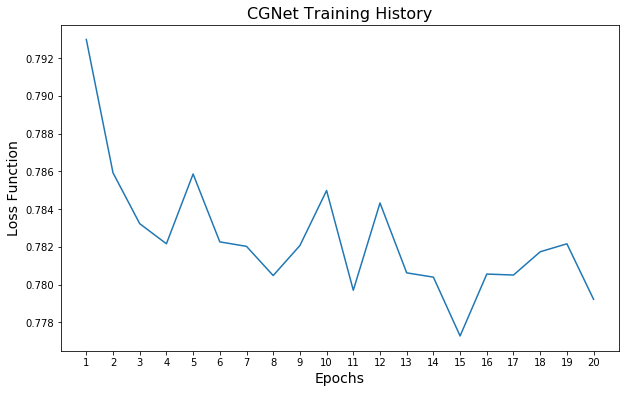

In [9]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, loss_4channel)
plt.ylabel('Loss Function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History', fontsize=16)
#plt.savefig('../figures/toSCP/trained_cgnet_040523_loss_epochs.png', bbox_inches='tight')

In [20]:
loss_4channel_40epochs = [0.792975664138794, 0.7859160900115967, 0.7832168340682983, 0.7821755409240723, 0.7858489155769348, 0.7822825312614441, 0.7820216417312622, 
                          0.7804549336433411, 0.7819924354553223, 0.7849681377410889, 0.7796165943145752, 0.7843264937400818, 0.7806426882743835, 0.7805047035217285, 
                          0.777405858039856, 0.7806576490402222, 0.7805306315422058, 0.7819859385490417, 0.7824258804321289, 0.7793174982070923, 0.7803518772125244, 
                          0.7779192924499512, 0.7811851501464844, 0.7819897532463074, 0.7769255638122559, 0.7807081937789917, 0.7782014012336731, 0.7794380187988281, 
                          0.7804199457168579, 0.7762503623962402, 0.7784111499786377, 0.7778763175010681, 0.7801409363746643, 0.7817971110343933, 0.7775568962097168, 
                          0.7801656723022461, 0.7780803442001343, 0.7761688232421875, 0.7796516418457031]

In [24]:
epoch_range = np.arange(1, config.epochs) # missing epoch 33

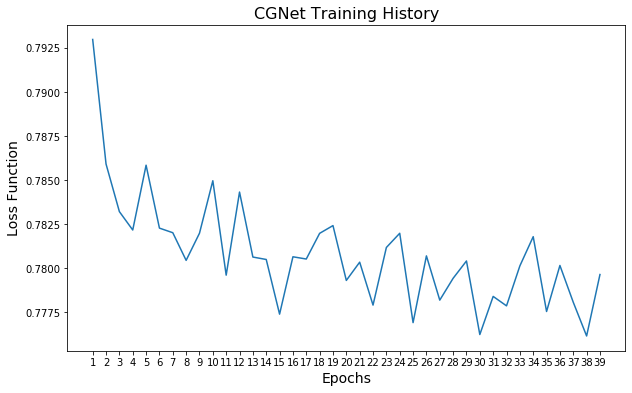

In [36]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, loss_4channel_40epochs)
plt.ylabel('Loss Function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History', fontsize=16)
#plt.savefig('../figures/toSCP/trained_cgnet_112425_loss_epochs.png', bbox_inches='tight')

In [30]:
loss_4channel_40epochs[19]

0.7793174982070923

In [29]:
# difference in loss between epoch 40 and epoch 20 is very small (actually increases by ~0.04%)
loss_4channel_40epochs[-1] - loss_4channel_40epochs[19]

0.00033414363861083984

### IOU across epochs

In [10]:
# list of lists...
iou_4channel = [[0.82468027, 0.02955234, 0.20687647], [0.93040919, 0.24552735, 0.3499208 ], [0.93507817, 0.28566718, 0.37940629], [0.93728455, 0.31748401, 0.39551527],
                [0.93909495, 0.32430877, 0.40609776], [0.93881926, 0.32837483, 0.40964832], [0.94105241, 0.34036034, 0.42090875], [0.94089294, 0.34384409, 0.42345722],
                [0.94162572, 0.34306023, 0.42858825], [0.94344054, 0.34477355, 0.43985051], [0.94310998, 0.3519992, 0.43998411], [0.94407983, 0.34748465, 0.44698649],
                [0.94474442, 0.35277528, 0.45147414], [0.94506546, 0.35476714, 0.45588776], [0.94535843, 0.35674451, 0.45620809], [0.94492276, 0.35737601, 0.45649445],
                [0.94581481, 0.36649505, 0.46129547], [0.94701946, 0.36918933, 0.4702124 ], [0.94752383, 0.36973565, 0.47586048], [0.94800169, 0.37387946, 0.47704684]]

In [11]:
config.labels

['Background', 'Tropical Cyclone', 'Atmospheric River']

In [12]:
iou_4channel_mean = np.mean(iou_4channel, axis=1)
iou_4channel_mean

array([0.35370303, 0.50861911, 0.53338388, 0.55009461, 0.55650049,
       0.55894747, 0.5674405 , 0.56939808, 0.5710914 , 0.57602153,
       0.57836443, 0.57951699, 0.58299795, 0.58524012, 0.58610368,
       0.58626441, 0.59120178, 0.59547373, 0.59770665, 0.59964266])

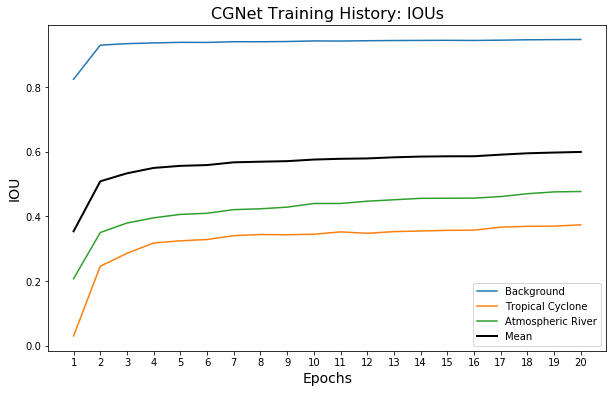

In [13]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, iou_4channel)
plt.plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean']);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_iou_epochs.png', bbox_inches='tight')

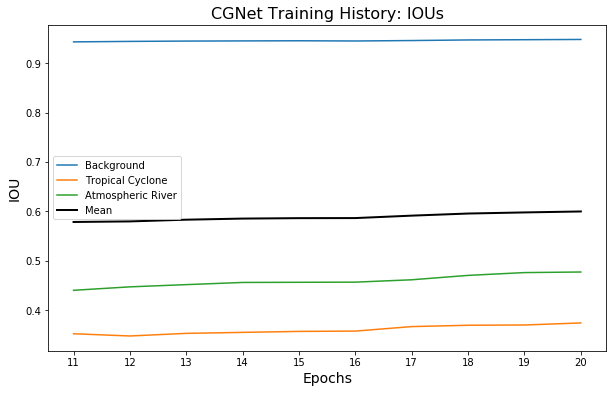

In [14]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range[10:], iou_4channel[10:])
plt.plot(epoch_range[10:], iou_4channel_mean[10:], color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range[10:]);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean']);

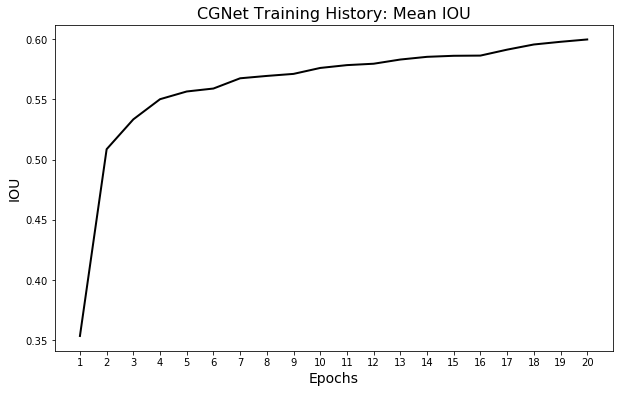

In [15]:
plt.figure(figsize=(10,6))
#plt.plot(epoch_range[10:], iou_4channel[10:])
plt.plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: Mean IOU', fontsize=16);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_mean-iou_epochs.png', bbox_inches='tight')

In [16]:
# testing results from below
iou_4channel_test = [0.9450045, 0.35225587, 0.39795872]

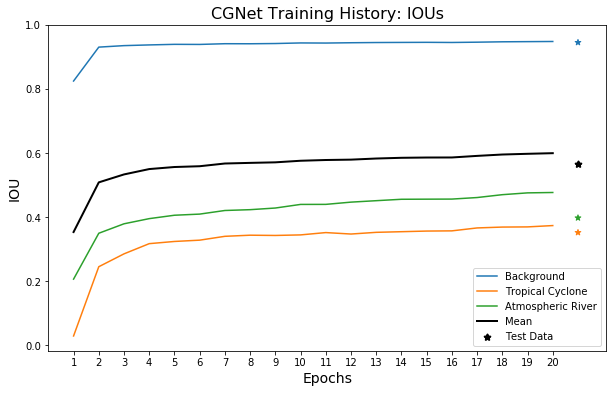

In [17]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, iou_4channel)
plt.plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
plt.scatter([21], np.mean(iou_4channel_test), marker='*', color='k', linewidth=2)
plt.scatter([21,21,21], iou_4channel_test, marker='*', color=['C0','C1','C2'])
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean', 'Test Data']);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_iou_epochs_testdata.png', bbox_inches='tight')

In [32]:
iou_4channel_40epochs = [[0.8246786, 0.02956616, 0.20687377,],[0.93042113, 0.24573198, 0.35004467],[0.93506109, 0.28594615, 0.37947577],[0.93726698, 0.31778875, 0.39547587],
                [0.93912225, 0.32474629, 0.4061769],[0.93876782, 0.32822364, 0.40952571],[0.94102783, 0.34045933, 0.42071192],[0.94083939, 0.34370844, 0.42324618],
                [0.94171407, 0.34367658, 0.42940211],[0.94343707, 0.34435729, 0.4401364],[0.94311233, 0.35275965, 0.44027552],[0.9441438, 0.34816154, 0.44788611],
                [0.94456558, 0.35207619, 0.4502546],[0.94513867, 0.35415388, 0.45665542],[0.94557827, 0.35607608, 0.45817527],[0.94525629, 0.35884011, 0.45880874],
                [0.94609955, 0.36737315, 0.46206579],[0.94671524, 0.36868828, 0.46796614],[0.94753999, 0.37001229, 0.47509292],[0.94776564, 0.37212005, 0.47616433],
                [0.94870503, 0.37477069, 0.48255124],[0.94892932, 0.3760448, 0.48630271],[0.94897704, 0.38163754, 0.48635595],[0.94844581, 0.37770016, 0.48355782],
                [0.95000531, 0.38216264, 0.49358781],[0.94982337, 0.38083327, 0.49616803],[0.95058533, 0.38375102, 0.49987218],[0.95088803, 0.38212277, 0.50494527],
                [0.9519337, 0.39174214, 0.51022692],[0.95183222, 0.39528641, 0.51062107],[0.95252868, 0.39880624, 0.51584188],[0.95162843, 0.39543312, 0.51192589],
                [0.95317394, 0.40402229, 0.52102699],[0.95336086, 0.40316847, 0.52457887],[0.95393705, 0.40984147, 0.52733548],[0.95320452, 0.41009387, 0.52426387],
                [0.95381847, 0.41442724, 0.52765377],[0.9541899, 0.41717681, 0.53107418],[0.9541436, 0.41563966, 0.532852]]

In [34]:
iou_4channel_40epochs_mean = np.mean(iou_4channel_40epochs, axis=1)
iou_4channel_40epochs_mean

array([0.35370618, 0.50873259, 0.53349434, 0.5501772 , 0.55668181,
       0.55883906, 0.56739969, 0.56926467, 0.57159759, 0.57597692,
       0.57871583, 0.58006382, 0.58229879, 0.58531599, 0.58660987,
       0.58763505, 0.59184616, 0.59445655, 0.5975484 , 0.59868334,
       0.60200899, 0.60375894, 0.60565684, 0.6032346 , 0.60858525,
       0.60894156, 0.61140284, 0.61265202, 0.61796759, 0.61924657,
       0.62239227, 0.61966248, 0.62607441, 0.62703607, 0.63037133,
       0.62918742, 0.63196649, 0.63414696, 0.63421175])

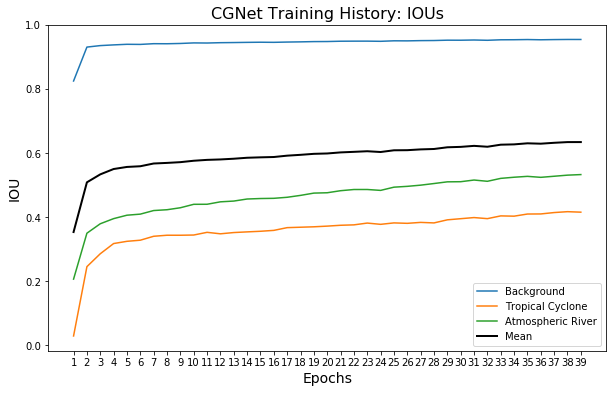

In [37]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, iou_4channel_40epochs)
plt.plot(epoch_range, iou_4channel_40epochs_mean, color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean']);
#plt.savefig('../figures/toSCP/trained_cgnet_112425_iou_epochs.png', bbox_inches='tight')

In [38]:
# difference in IOU between epoch 40 and epoch 20 is ~3%
iou_4channel_40epochs_mean[-1] - iou_4channel_40epochs_mean[19]

0.03552841333333323

In [41]:
# difference for ARs specifically is ~4%
iou_4channel_40epochs[-1][1] - iou_4channel_40epochs[19][1]

0.04351961000000004

In [43]:
# testing results from below
iou_4channel_40epochs_test = [0.942005, 0.35946696, 0.40571525]

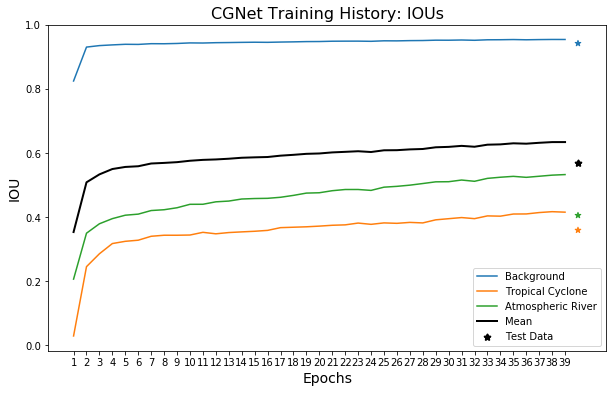

In [45]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, iou_4channel_40epochs)
plt.plot(epoch_range, iou_4channel_40epochs_mean, color='k', linewidth=2)
plt.scatter([40], np.mean(iou_4channel_40epochs_test), marker='*', color='k', linewidth=2)
plt.scatter([40,40,40], iou_4channel_40epochs_test, marker='*', color=['C0','C1','C2'])
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean', 'Test Data']);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_iou_epochs_testdata.png', bbox_inches='tight')

Performance on test data actually degrades relative to 20-epoch model - indicating 40 epochs is likely overtrained

### Panel plot for training results

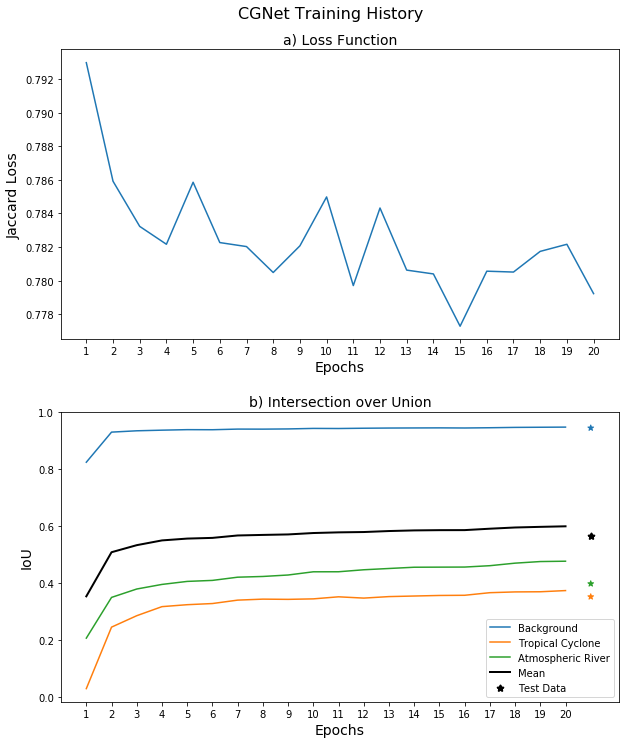

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10,12))

axs[0].plot(epoch_range, loss_4channel)
axs[0].set_ylabel('Jaccard Loss', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_xticks(epoch_range);
axs[0].set_title('a) Loss Function', fontsize=14)

axs[1].plot(epoch_range, iou_4channel)
axs[1].plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
axs[1].scatter([21], np.mean(iou_4channel_test), marker='*', color='k', linewidth=2)
axs[1].scatter([21,21,21], iou_4channel_test, marker='*', color=['C0','C1','C2'])
axs[1].set_ylabel('IoU', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_xticks(epoch_range);
axs[1].set_title('b) Intersection over Union', fontsize=14)
axs[1].legend(config.labels+['Mean', 'Test Data']);

fig.suptitle('CGNet Training History', fontsize=16, y=0.93);

plt.subplots_adjust(wspace=0, hspace=0.25)

#plt.savefig('../figures/toSCP/trained_cgnet_040523_loss_iou_epochs_testdata.png', dpi=300, bbox_inches='tight')

## Train model - TMQ, U850, V850

10/10/25\
Memory use holding at ~6GB during training (less than previous model training)\
Each epoch takes ~1 min to run

In [13]:
cgnet.train(train) # use ~20 epochs for non-test
# IOU mean should be around 0.75 after all epochs?

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.61476225e+08 2.91514240e+07 3.98930500e+07]
 [1.07261700e+06 1.30853000e+05 4.22877000e+05]
 [6.73527300e+06 1.10386800e+06 1.21387410e+07]]
IOUs:  [0.77284697 0.00410434 0.20132649] , mean:  0.3260925995847188
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1460135e+08 7.0135800e+05 1.5217991e+07]
 [9.9099900e+05 4.3737600e+05 1.9797200e+05]
 [8.6928740e+06 8.5508000e+04 1.1199500e+07]]
IOUs:  [0.92474169 0.18124219 0.31642507] , mean:  0.47413631569019793
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17134618e+08 8.75172000e+05 1.25109090e+07]
 [8.06832000e+05 7.09271000e+05 1.10244000e+05]
 [7.85622100e+06 1.29148000e+05 1.19925130e+07]]
IOUs:  [0.93499354 0.26961641 0.36787939] , mean:  0.5241631141514885
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17279394e+08 8.54281000e+05 1.23870240e+07]
 [7.61174000e+05 7.65852000e+05 9.93210000e+04]
 [7.16811300e+06 1.14279000e+05 1.26954900e+07]]
IOUs:  [0.93744839 0.29513659 0.39106091] , mean:  0.541215294200963
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17506375e+08 9.41814000e+05 1.20725100e+07]
 [6.89295000e+05 8.43724000e+05 9.33280000e+04]
 [6.94252700e+06 9.73270000e+04 1.29380280e+07]]
IOUs:  [0.93894428 0.31653641 0.40250562] , mean:  0.5526621032178374
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17135269e+08 9.32438000e+05 1.24529920e+07]
 [6.63687000e+05 8.61103000e+05 1.01557000e+05]
 [6.70618600e+06 9.40910000e+04 1.31776050e+07]]
IOUs:  [0.93857389 0.32459225 0.40506057] , mean:  0.5560755712635232
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17128674e+08 1.05804800e+06 1.23339770e+07]
 [6.23507000e+05 9.09290000e+05 9.35500000e+04]
 [6.53768200e+06 9.91890000e+04 1.33410110e+07]]
IOUs:  [0.93913439 0.3266616  0.41169087] , mean:  0.5591622861383225
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17960134e+08 1.01492600e+06 1.15456390e+07]
 [6.24212000e+05 9.18217000e+05 8.39180000e+04]
 [6.54781400e+06 9.10850000e+04 1.33389830e+07]]
IOUs:  [0.94156643 0.33605296 0.42202037] , mean:  0.5665465868454675
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17663975e+08 1.05267900e+06 1.18040450e+07]
 [5.99222000e+05 9.39916000e+05 8.72090000e+04]
 [6.24348800e+06 9.33860000e+04 1.36410080e+07]]
IOUs:  [0.94160767 0.33902465 0.42803194] , mean:  0.5695547527352737
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17810687e+08 1.10965200e+06 1.16003600e+07]
 [5.74588000e+05 9.67358000e+05 8.44010000e+04]
 [6.16094500e+06 9.31240000e+04 1.37238130e+07]]
IOUs:  [0.94234193 0.34192858 0.43343864] , mean:  0.5725697147696797
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18046514e+08 9.80843000e+05 1.14933420e+07]
 [5.96361000e+05 9.47481000e+05 8.25050000e+04]
 [6.02648300e+06 8.38010000e+04 1.38675980e+07]]
IOUs:  [0.94335639 0.35209371 0.43949157] , mean:  0.5783138888738897
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17714097e+08 1.09459400e+06 1.17120080e+07]
 [5.66964000e+05 9.77749000e+05 8.16340000e+04]
 [5.82148500e+06 8.66170000e+04 1.40697800e+07]]
IOUs:  [0.94302603 0.34825603 0.44284246] , mean:  0.578041508599715
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18366553e+08 1.10159900e+06 1.10525470e+07]
 [5.56763000e+05 9.87542000e+05 8.20420000e+04]
 [5.83186000e+06 9.21950000e+04 1.40538270e+07]]
IOUs:  [0.94496214 0.35017469 0.45171041] , mean:  0.5822824120511393
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17856112e+08 1.00804400e+06 1.16565430e+07]
 [5.75106000e+05 9.64971000e+05 8.62700000e+04]
 [5.69115000e+06 7.95160000e+04 1.42072160e+07]]
IOUs:  [0.94378986 0.35556524 0.44788476] , mean:  0.5824132877276528
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18146342e+08 1.13916400e+06 1.12351930e+07]
 [5.31390000e+05 1.01264500e+06 8.23120000e+04]
 [5.59912600e+06 8.62380000e+04 1.42925180e+07]]
IOUs:  [0.94503251 0.35509612 0.45669728] , mean:  0.5856086340976199
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18233829e+08 1.06373500e+06 1.12231350e+07]
 [5.77011000e+05 9.59209000e+05 9.01270000e+04]
 [5.48871400e+06 8.01690000e+04 1.44089990e+07]]
IOUs:  [0.94547435 0.34625346 0.46048169] , mean:  0.5840698340134826
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18148011e+08 1.13075600e+06 1.12419320e+07]
 [5.27439000e+05 1.01685200e+06 8.20560000e+04]
 [5.45700800e+06 8.21220000e+04 1.44387520e+07]]
IOUs:  [0.94544768 0.35814421 0.46127442] , mean:  0.5882887727769034
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18697708e+08 1.10363700e+06 1.07193540e+07]
 [5.32611000e+05 1.01642800e+06 7.73080000e+04]
 [5.36200300e+06 8.17240000e+04 1.45341550e+07]]
IOUs:  [0.94733413 0.36149842 0.47227848] , mean:  0.5937036783487302
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18052755e+08 1.06203200e+06 1.14059120e+07]
 [5.21489000e+05 1.01931000e+06 8.55480000e+04]
 [5.18773700e+06 7.87510000e+04 1.47113940e+07]]
IOUs:  [0.94593827 0.36836361 0.46748337] , mean:  0.5939284180147941
Epoch 20:


Loss: 0.7799063324928284: 100%|██████████| 25/25 [01:05<00:00,  2.62s/it]

Epoch stats:
[[3.18504437e+08 1.11317200e+06 1.09030900e+07]
 [4.99762000e+05 1.04518900e+06 8.13960000e+04]
 [5.16501600e+06 8.45210000e+04 1.47283450e+07]]
IOUs:  [0.94740689 0.37010418 0.47568535] , mean:  0.5977321402913692


10/10/25: Training is maxing out around 0.5977 IOU mean at last epoch

## Train model - TMQ, V850

Memory use holding at ~12GB during training\
Each epoch takes ~1 min to run

In [11]:
%%time
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.67465901e+08 3.57088010e+07 2.73459970e+07]
 [1.03063000e+06 3.48909000e+05 2.46808000e+05]
 [8.90030200e+06 1.60290200e+06 9.47467800e+06]]
IOUs:  [0.78562085 0.00896062 0.19917051] , mean:  0.3312506607117836
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16022333e+08 1.03130400e+06 1.34670620e+07]
 [1.07174800e+06 4.20121000e+05 1.34478000e+05]
 [8.50047600e+06 1.13408000e+05 1.13639980e+07]]
IOUs:  [0.92922349 0.15161027 0.33842149] , mean:  0.4730850828498043
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16828427e+08 9.02941000e+05 1.27893310e+07]
 [8.93811000e+05 6.19459000e+05 1.13077000e+05]
 [7.59652800e+06 1.14034000e+05 1.22673200e+07]]
IOUs:  [0.9345667  0.23434867 0.37309038] , mean:  0.5140019183494055
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17239392e+08 8.71752000e+05 1.24095550e+07]
 [8.19333000e+05 6.97907000e+05 1.09107000e+05]
 [7.17216300e+06 1.03660000e+05 1.27020590e+07]]
IOUs:  [0.93715794 0.26824429 0.39087415] , mean:  0.5320921277325162
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17103897e+08 9.32084000e+05 1.24847180e+07]
 [7.37931000e+05 7.81798000e+05 1.06618000e+05]
 [6.95439700e+06 9.12360000e+04 1.29322490e+07]]
IOUs:  [0.93758629 0.29505519 0.39706968] , mean:  0.5432370534226606
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17638183e+08 9.13228000e+05 1.19692880e+07]
 [6.95001000e+05 8.27213000e+05 1.04133000e+05]
 [6.81995700e+06 8.04160000e+04 1.30775090e+07]]
IOUs:  [0.93965881 0.31573124 0.40801801] , mean:  0.5544693535965578
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17645556e+08 9.58735000e+05 1.19164080e+07]
 [6.69070000e+05 8.64044000e+05 9.32330000e+04]
 [6.76188600e+06 8.99450000e+04 1.31260510e+07]]
IOUs:  [0.93991419 0.32300384 0.41034909] , mean:  0.5577557079336068
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17617959e+08 1.06870700e+06 1.18340330e+07]
 [6.46515000e+05 8.88955000e+05 9.08770000e+04]
 [6.43352000e+06 8.81220000e+04 1.34562400e+07]]
IOUs:  [0.94080944 0.31940308 0.42178879] , mean:  0.5606671060544012
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17591735e+08 9.50123000e+05 1.19788410e+07]
 [6.44885000e+05 8.81981000e+05 9.94810000e+04]
 [6.28976700e+06 7.67120000e+04 1.36114030e+07]]
IOUs:  [0.94113705 0.33242386 0.42461057] , mean:  0.5660571606733165
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17664698e+08 9.94052000e+05 1.18619490e+07]
 [6.26253000e+05 9.10928000e+05 8.91660000e+04]
 [6.24123000e+06 8.49410000e+04 1.36517110e+07]]
IOUs:  [0.94154068 0.33671479 0.42756467] , mean:  0.5686067135812413
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17938264e+08 9.94661000e+05 1.15877740e+07]
 [6.16863000e+05 9.17957000e+05 9.15270000e+04]
 [6.08511400e+06 7.84680000e+04 1.38143000e+07]]
IOUs:  [0.94281401 0.34005007 0.43637174] , mean:  0.5730786065887492
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18184245e+08 1.00032200e+06 1.13361320e+07]
 [5.97795000e+05 9.41979000e+05 8.65730000e+04]
 [5.92710900e+06 8.13370000e+04 1.39694360e+07]]
IOUs:  [0.94403915 0.34784967 0.44487818] , mean:  0.5789223346143332
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18011244e+08 1.01001200e+06 1.14994430e+07]
 [5.89306000e+05 9.43445000e+05 9.35960000e+04]
 [5.81776400e+06 7.47400000e+04 1.40853780e+07]]
IOUs:  [0.94385584 0.34799356 0.44615037] , mean:  0.579333258238884
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18033228e+08 9.89248000e+05 1.14982230e+07]
 [5.98231000e+05 9.38768000e+05 8.93480000e+04]
 [5.84485700e+06 7.91840000e+04 1.40538410e+07]]
IOUs:  [0.9438202  0.34836549 0.44522855] , mean:  0.5791380797120701
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18469246e+08 1.01845500e+06 1.10329980e+07]
 [6.07922000e+05 9.33354000e+05 8.50710000e+04]
 [5.77961400e+06 7.77110000e+04 1.41205570e+07]]
IOUs:  [0.94527    0.34282812 0.45409632] , mean:  0.580731477967095
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18273513e+08 1.04619500e+06 1.12009910e+07]
 [5.67483000e+05 9.71889000e+05 8.69750000e+04]
 [5.54396000e+06 7.99110000e+04 1.43540110e+07]]
IOUs:  [0.94546383 0.35309922 0.45909553] , mean:  0.5858861905516117
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18590595e+08 1.02865400e+06 1.09014500e+07]
 [5.76493000e+05 9.65659000e+05 8.41950000e+04]
 [5.52842700e+06 8.07270000e+04 1.43687280e+07]]
IOUs:  [0.94642409 0.35298063 0.46405334] , mean:  0.5878193527419585
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18595291e+08 1.05134000e+06 1.08740680e+07]
 [5.64487000e+05 9.78873000e+05 8.29870000e+04]
 [5.42933800e+06 7.90550000e+04 1.44694890e+07]]
IOUs:  [0.94675049 0.35508328 0.4677394 ] , mean:  0.5898577262558553
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18708072e+08 1.00919900e+06 1.08034280e+07]
 [5.63307000e+05 9.80795000e+05 8.22450000e+04]
 [5.39482500e+06 7.93020000e+04 1.45037550e+07]]
IOUs:  [0.9471861  0.36127069 0.46993145] , mean:  0.5927960774207156
Epoch 20:


Loss: 0.775212824344635: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it] 

Epoch stats:
[[3.18759946e+08 1.02135900e+06 1.07393940e+07]
 [5.59122000e+05 9.88235000e+05 7.89900000e+04]
 [5.16193600e+06 7.68240000e+04 1.47391220e+07]]
IOUs:  [0.94800821 0.36271761 0.47860094] , mean:  0.5964422534915425
CPU times: user 10min 48s, sys: 6min 10s, total: 16min 58s
Wall time: 19min 54s


9/20/23: Training is maxing out at 0.5964 IOU mean at last epoch

## Train model - TMQ

Memory use holding at ~13GB during training\
Each epoch takes ~1 min to run

In [34]:
%%time
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.84238956e+08 1.84050650e+07 2.78766780e+07]
 [1.13390200e+06 3.04555000e+05 1.87890000e+05]
 [8.54513000e+06 9.36724000e+05 1.04960280e+07]]
IOUs:  [0.83550612 0.01452466 0.21847404] , mean:  0.3561682703590215
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18264835e+08 9.21300000e+03 1.22466510e+07]
 [1.51578700e+06 6.59000000e+02 1.09901000e+05]
 [8.70045200e+06 3.20000000e+01 1.12773980e+07]]
IOUs:  [9.34048527e-01 4.02912218e-04 3.48773632e-01] , mean:  0.42774169052947997
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18341276e+08 0.00000000e+00 1.21794230e+07]
 [1.51056500e+06 4.60000000e+01 1.15736000e+05]
 [7.83816600e+06 0.00000000e+00 1.21397160e+07]]
IOUs:  [9.36657575e-01 2.82842468e-05 3.76156557e-01] , mean:  0.4376141387704749
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18172222e+08 0.00000000e+00 1.23484770e+07]
 [1.50147300e+06 1.00000000e+00 1.24873000e+05]
 [7.31193400e+06 0.00000000e+00 1.26659480e+07]]
IOUs:  [9.37637026e-01 6.14874931e-07 3.90307154e-01] , mean:  0.4426482649288845
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18501659e+08 0.00000000e+00 1.20190400e+07]
 [1.50758200e+06 0.00000000e+00 1.18765000e+05]
 [7.13927700e+06 0.00000000e+00 1.28386050e+07]]
IOUs:  [0.93906876 0.         0.39976118] , mean:  0.44627664823791297
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18495846e+08 0.00000000e+00 1.20248530e+07]
 [1.50062500e+06 0.00000000e+00 1.25722000e+05]
 [6.94342000e+06 0.00000000e+00 1.30344620e+07]]
IOUs:  [0.93961349 0.         0.40569835] , mean:  0.4484372799779974
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18512677e+08 0.00000000e+00 1.20080220e+07]
 [1.50574400e+06 0.00000000e+00 1.20603000e+05]
 [6.68270000e+06 0.00000000e+00 1.32951820e+07]]
IOUs:  [0.94037224 0.         0.41409618] , mean:  0.45148947581739085
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18696912e+08 0.00000000e+00 1.18237870e+07]
 [1.49548000e+06 0.00000000e+00 1.30867000e+05]
 [6.54836000e+06 0.00000000e+00 1.34295220e+07]]
IOUs:  [0.94131805 0.         0.42055921] , mean:  0.45395908582630345
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1871988e+08 0.0000000e+00 1.1800819e+07]
 [1.5046830e+06 0.0000000e+00 1.2166400e+05]
 [6.5041360e+06 0.0000000e+00 1.3473746e+07]]
IOUs:  [0.94148328 0.         0.42236965] , mean:  0.4546176423657821
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18754025e+08 0.00000000e+00 1.17666740e+07]
 [1.50638400e+06 0.00000000e+00 1.19963000e+05]
 [6.39829800e+06 0.00000000e+00 1.35795840e+07]]
IOUs:  [0.94187387 0.         0.42616629] , mean:  0.4560133899553898
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19092355e+08 0.00000000e+00 1.14283440e+07]
 [1.50480600e+06 0.00000000e+00 1.21541000e+05]
 [6.25503800e+06 0.00000000e+00 1.37228440e+07]]
IOUs:  [0.94327729 0.         0.43526216] , mean:  0.4595131514989932
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18760685e+08 0.00000000e+00 1.17600140e+07]
 [1.50223600e+06 0.00000000e+00 1.24111000e+05]
 [6.03913100e+06 0.00000000e+00 1.39387510e+07]]
IOUs:  [0.94290581 0.         0.43747247] , mean:  0.46012609320876047
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19542161e+08 0.00000000e+00 1.09785380e+07]
 [1.49686900e+06 0.00000000e+00 1.29478000e+05]
 [6.06905200e+06 0.00000000e+00 1.39088300e+07]]
IOUs:  [0.94514879 0.         0.44743214] , mean:  0.46419364594567664
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19171032e+08 0.00000000e+00 1.13496670e+07]
 [1.49944300e+06 0.00000000e+00 1.26904000e+05]
 [5.81475700e+06 0.00000000e+00 1.41631250e+07]]
IOUs:  [0.94475447 0.         0.45027408] , mean:  0.4650095189034851
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18931613e+08 0.00000000e+00 1.15890860e+07]
 [1.49573800e+06 0.00000000e+00 1.30609000e+05]
 [5.73924800e+06 0.00000000e+00 1.42386340e+07]]
IOUs:  [0.94426719 0.         0.4492026 ] , mean:  0.4644899313778658
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19497912e+08 0.00000000e+00 1.10227870e+07]
 [1.50557200e+06 0.00000000e+00 1.20775000e+05]
 [5.65231200e+06 0.00000000e+00 1.43255700e+07]]
IOUs:  [0.94615983 0.         0.46031187] , mean:  0.4688239003895394
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19636151e+08 0.00000000e+00 1.08845480e+07]
 [1.51050400e+06 0.00000000e+00 1.15843000e+05]
 [5.46656400e+06 0.00000000e+00 1.45113180e+07]]
IOUs:  [0.94707634 0.         0.46843534] , mean:  0.47183722938879064
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19583461e+08 0.00000000e+00 1.09372380e+07]
 [1.49381900e+06 0.00000000e+00 1.32528000e+05]
 [5.28747200e+06 0.00000000e+00 1.46904100e+07]]
IOUs:  [0.94746984 0.         0.47315694] , mean:  0.4735422572121362
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19838486e+08 0.00000000e+00 1.06822130e+07]
 [1.50151900e+06 1.40000000e+01 1.24814000e+05]
 [5.37105700e+06 0.00000000e+00 1.46068250e+07]]
IOUs:  [9.47969357e-01 8.60824904e-06 4.74480045e-01] , mean:  0.47415267004189765
Epoch 20:


Loss: 0.7837892174720764: 100%|██████████| 25/25 [01:03<00:00,  2.53s/it]

Epoch stats:
[[3.19462395e+08 6.00000000e+00 1.10582980e+07]
 [1.48727600e+06 0.00000000e+00 1.39071000e+05]
 [5.10564100e+06 0.00000000e+00 1.48722410e+07]]
IOUs:  [0.94764014 0.         0.47705281] , mean:  0.47489764974583665
CPU times: user 10min 16s, sys: 5min 36s, total: 15min 53s
Wall time: 18min 50s


9/20/23: Training is maxing out at 0.4749 IOU mean at last epoch

### TO DO: output masks during training so we can visually check match between training data and what model predicts?
Instead of simply relying on IOU. Also check the loss function here.\
Below, have found a way to save out testing data masks to compare predictions vs. labels on the test data.

### TO DO: play with batch size, other hyperparameters; random seed for spread
See CGnet papers (Kapp-Schwoerer et al. and Lacombe et al.)

## Evaluate model on test data - TMQ, U850, V850, PSL

### Model trained for 20 epochs

In [15]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [16]:
test.length

61

In [16]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

Evaluation stats:
[[4.9207437e+07 1.6860800e+05 1.2782570e+06]
 [1.2489300e+05 1.6929100e+05 2.4100000e+03]
 [1.2919190e+06 1.5389000e+04 1.7106920e+06]]
IOUs:  [0.9450045  0.35225587 0.39795872] , mean:  0.5650730277914003
CPU times: user 1.64 s, sys: 1.65 s, total: 3.29 s
Wall time: 9.97 s


### Model trained for 40 epochs

In [42]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

Evaluation stats:
[[4.8628457e+07 1.5050400e+05 1.8753410e+06]
 [1.3578700e+05 1.5614100e+05 4.6660000e+03]
 [1.0804920e+06 1.3536000e+04 1.9239720e+06]]
IOUs:  [0.9374959  0.33896977 0.39280712] , mean:  0.5564242608753748
CPU times: user 1.92 s, sys: 2.92 s, total: 4.84 s
Wall time: 11.6 s


## Evaluate model on test data - TMQ, U850, V850

In [14]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541}}

In [15]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]

Evaluation stats:
[[4.8896844e+07 1.3741600e+05 1.6200420e+06]
 [1.3091100e+05 1.6039200e+05 5.2910000e+03]
 [1.1219450e+06 1.2184000e+04 1.8838710e+06]]
IOUs:  [0.9420058  0.35946696 0.40571525] , mean:  0.5690626694567106
CPU times: user 1.8 s, sys: 1.68 s, total: 3.48 s
Wall time: 10 s


10/10/25: Testing data is at 0.569 IOU mean

## Evaluate model on test data - TMQ, V850

In [12]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541}}

In [15]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

Evaluation stats:
[[4.8270906e+07 1.7247800e+05 2.2109180e+06]
 [1.2835800e+05 1.6712400e+05 1.1120000e+03]
 [9.6592800e+05 1.7096000e+04 2.0349760e+06]]
IOUs:  [0.93279658 0.34375771 0.38909452] , mean:  0.5552162709391156
CPU times: user 1.42 s, sys: 1.16 s, total: 2.59 s
Wall time: 9.23 s


9/20/23: Testing data is at 0.55 IOU mean\
Similar (perhaps slightly degraded) performance to 4 input fields version

## Evaluate model on test data - TMQ

In [82]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879}}

In [83]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:15<00:00,  3.77s/it]

Evaluation stats:
[[4.9289379e+07 0.0000000e+00 1.3649230e+06]
 [2.9495600e+05 0.0000000e+00 1.6380000e+03]
 [1.3877350e+06 0.0000000e+00 1.6302650e+06]]
IOUs:  [0.94176941 0.         0.37181944] , mean:  0.4378629486893792
CPU times: user 1.24 s, sys: 985 ms, total: 2.22 s
Wall time: 15.1 s


9/20/23: Testing data is at 0.43 IOU mean\
Unable to detect TCs with just TMQ but AR performance is similar (slightly degraded as you remove input fields)

## Save out model

### Makes a folder by the name specified, puts the trained model and config file in there

In [46]:
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.021523') # TMQ, U850, V850, PSL; weighted means and unweighted std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523') # TMQ, U850, V850, PSL; unweighted means/std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.092023_TMQ_V850') # TMQ, V850; unweighted means/std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.092023_TMQ') # TMQ; unweighted means/std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.101025_TMQ_U850_V850') # TMQ, U850, V850; unweighted means/std in config file
cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.112425') # TMQ, U850, V850, PSL; unweighted means/std in config file; trained for 40 epochs

## Load in previously trained model

In [8]:
#cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.021523') # TMQ, U850, V850, PSL; weighted means and unweighted std in config file
#cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523') # TMQ, U850, V850, PSL; unweighted means/std in config file
cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.101025_TMQ_U850_V850') # TMQ, U850, V850; unweighted means/std in config file

## Predict on test data
Need to reload test data as `ClimateDataset` in order to use `.predict`

In [9]:
test_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new/test"
test_data = ClimateDataset(test_path, config)

In [10]:
%%time
test_masks = cgnet.predict(test_data)

100%|██████████| 4/4 [00:27<00:00,  6.83s/it]

CPU times: user 3.11 s, sys: 1.78 s, total: 4.89 s
Wall time: 27.5 s


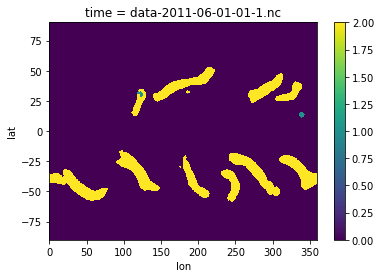

In [11]:
test_masks.isel(time=0).plot();

## Save out test data masks

In [35]:
%%time
test_masks.name = 'masks'
test_masks.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/evaluate/test_masks.040523.nc") # trained_cgnet.040523 applied to test data to evaluate predictions vs. labels

CPU times: user 2.35 ms, sys: 142 ms, total: 144 ms
Wall time: 168 ms


## Set inference data

In [12]:
year=2000
#inference_path = "/glade/campaign/cgd/amp/jet/ClimateNet/Climate_data_"+str(year)
#inference_path = "/glade/scratch/tking/cgnet/historical_2000_2005/split_files"
inference_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/"+str(year)

inference = ClimateDataset(inference_path, config)  # could test different config with std/means for inference data

In [13]:
inference.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541}}

In [14]:
inference.length

2920

## Inference mode
This is now done more systematically in `cgnet_run_pre_trained_model.ipynb`.

In [15]:
%%time
class_masks = cgnet.predict(inference) # masks with 1==TC, 2==AR

100%|██████████| 183/183 [05:50<00:00,  1.91s/it]


CPU times: user 2min 41s, sys: 37 s, total: 3min 18s
Wall time: 5min 57s


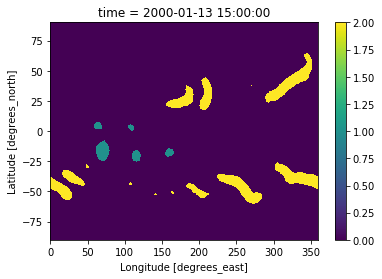

In [18]:
class_masks.isel(time=100).plot();

## Save out masks

In [21]:
%%time
#class_masks.to_netcdf("/glade/scratch/kdagon/cgnet/class_masks."+str(year)+".nc")
class_masks.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/"+str(year)+"/masks_TMQ_U850_V850/class_masks.nc")

CPU times: user 47.4 ms, sys: 5.22 s, total: 5.27 s
Wall time: 5.78 s


## Track events
Create masks with event IDs\
This is now done in ``cgnet_analyze_events.ipynb``

Note: memory spikes here - resource intensive!

In [ ]:
%%time
event_masks = track_events(class_masks)

In [ ]:
%%time
event_masks.to_netcdf("/glade/scratch/kdagon/cgnet/event_masks."+str(year)+".test.nc")

## Analyze events
Produce some visualizations\
This is now done in `cgnet_analyze_events.ipynb`

In [ ]:
analyze_events(event_masks, class_masks, "/glade/scratch/kdagon/cgnet/")

In [ ]:
visualize_events(event_masks, inference, "/glade/scratch/kdagon/cgnet/")   

## Playing around with Weights and Biases
https://docs.wandb.ai/quickstart \
Potential tool for hyperparameter optimization

In [42]:
import wandb

In [44]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /glade/u/home/kdagon/.netrc


True

In [46]:
wandb.init(project="climatenet-test", entity="katie-dagon")

Ignoring settings passed to wandb.setup() which has already been configured.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /glade/u/home/kdagon/.netrc
wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20230215_172859-2auiboc1
wandb: Syncing run decent-river-1


In [47]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 20,
  "batch_size": 16
}

In [49]:
wandb.log({"loss": loss})

NameError: name 'loss' is not defined